# COMPARE COMPRESSION FACTORS OF VARIOUS METHODS

In [1]:
using PyCall, PyPlot
using JLD2, FileIO, NetCDF
using StatsBase, Statistics, BitInformation
using ZfpCompression, TranscodingStreams, CodecZstd

ticker = pyimport("matplotlib.ticker");

ZstdCompressorL3 = ZstdCompressor(level=3)
TranscodingStreams.initialize(ZstdCompressorL3)

ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [2]:
path = "/network/aopp/chaos/pred/kloewer/esowc/"
member1files = filter(x->endswith(x,".nc"),readdir(joinpath(path,"member1")))
steps = [parse(Int,split(split(file,"step")[2],".")[1]) for file in member1files]
sort!(steps)

ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step0.ll.nc"))
temp = ncfile.vars["t"][:,:,:];

In [3]:
Nens = 25
Nbytes = 4   # 4 bytes for float32
Nsteps = length(steps)
Nlon,Nlat,Nvert = size(temp)

(1800, 901, 91)

In [4]:
# precision options
keepbits100 = 15
keepbits99 = 9

precision100 = 22
precision99 = 14

14

## 1. ZFP: Compress only horizontal 2D

In [5]:
cfs_zfp_2d_hori_all99 = fill(0.0,Nvert)
cfs_zfp_2d_hori_all100 = fill(0.0,Nvert)

ori_size = Nlon*Nlat*Nbytes*2   # relative to Float64

for iv in 1:Nvert
    print("$iv,")
    s = steps[rand(1:Nsteps)]    # pick a random time step
    m = rand(1:Nens)             # pick a random ensemble member
    
    # load file
    ncfile = NetCDF.open(joinpath(path,"member$m","ensemble.t.member$m.step$s.ll.nc"))
    temp = ncfile.vars["t"][:,:,iv];
    
    # compress only vertical level
    cfs_zfp_2d_hori_all99[iv] = ori_size/sizeof(zfp_compress(temp,precision=precision99))
    cfs_zfp_2d_hori_all100[iv] = ori_size/sizeof(zfp_compress(temp,precision=precision100))
end

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,

In [6]:
extrema(cfs_zfp_2d_hori_all99)

(20.339365664622445, 23.921412451878403)

In [7]:
extrema(cfs_zfp_2d_hori_all100)

(6.336072010407754, 8.414706279120447)

## 2. ZFP: Compress spatial 3D

In [ ]:
cfs_zfp_3d_space_all99 = fill(0.0,Nens)
cfs_zfp_3d_space_all100 = fill(0.0,Nens)
ori_size = Nlon*Nlat*Nvert*Nbytes*2   # relative to Float64

for ie in 1:Nens
    print("$ie,")
    s = steps[rand(1:Nsteps)] # pick a random time step
    
    # load member ie
    ncfile = NetCDF.open(joinpath(path,"member$ie","ensemble.t.member$ie.step$s.ll.nc"))
    temp = ncfile.vars["t"][:,:,:];
    
    # compress the 3d field
    cfs_zfp_3d_space_all99[ie] = ori_size/sizeof(zfp_compress(temp,precision=precision99,nthreads=4))
    cfs_zfp_3d_space_all100[ie] = ori_size/sizeof(zfp_compress(temp,precision=precision100,nthreads=4))
end

In [ ]:
extrema(cfs_zfp_3d_space_all99)

In [ ]:
extrema(cfs_zfp_3d_space_all100)

In [8]:
# @save joinpath(path,"analysis","compressfac_zfp_3d_space.jld2") cfs_zfp_3d_space_all99 cfs_zfp_3d_space_all100
@load joinpath(path,"analysis","compressfac_zfp_3d_space.jld2") cfs_zfp_3d_space_all99 cfs_zfp_3d_space_all100

2-element Vector{Symbol}:
 :cfs_zfp_3d_space_all99
 :cfs_zfp_3d_space_all100

## 3. ZFP: Compress horizontal + time 3D

In [ ]:
cfs_zfp_3d_horitime_all99 = fill(0.0,Nvert)
cfs_zfp_3d_horitime_all100 = fill(0.0,Nvert)
Nsteps1h = 91                             # there are 91 steps with dt=1h
ori_size = Nlon*Nlat*Nbytes*2*Nsteps1h    # relative to Float64

for iv in 1:Nvert
    print("$iv,")
    temp = fill(0.0,Nlon,Nlat,Nsteps1h)
    
    for i in 1:Nsteps1h
        t = steps[i]
        
        # load time steps
        ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$t.ll.nc"))
        temp[:,:,i] = ncfile.vars["t"][:,:,iv];
    end
    
    cfs_zfp_3d_horitime_all99[iv] = ori_size/sizeof(zfp_compress(temp,precision=precision99,nthreads=4))
    cfs_zfp_3d_horitime_all100[iv] = ori_size/sizeof(zfp_compress(temp,precision=precision100,nthreads=4))
end

In [ ]:
extrema(cfs_zfp_3d_horitime_all99)

In [ ]:
extrema(cfs_zfp_3d_horitime_all100)

In [9]:
# @save joinpath(path,"analysis","compressfac_zfp_3d_horitime.jld2") cfs_zfp_3d_horitime_all99 cfs_zfp_3d_horitime_all100
@load joinpath(path,"analysis","compressfac_zfp_3d_horitime.jld2") cfs_zfp_3d_horitime_all99 cfs_zfp_3d_horitime_all100

2-element Vector{Symbol}:
 :cfs_zfp_3d_horitime_all99
 :cfs_zfp_3d_horitime_all100

## 4. ZFP: Compress in space and time

In [ ]:
chunksize = 8
Nsteps1h = 91                              # there are 91 steps with dt=1h
Nchunks = Nsteps1h÷chunksize               # compress in chunks of 4 time steps
cfs_zfp_4d_spacetime99 = fill(0.0,Nchunks)
cfs_zfp_4d_spacetime100 = fill(0.0,Nchunks)
ori_size = Nlon*Nlat*Nvert*Nbytes*2*chunksize      # relative to Float64

for ic in 1:Nchunks
    print("$ic")
    
    temp = fill(0f0,Nlon,Nlat,Nvert,chunksize)
    for i in 1:chunksize
        s = steps[(ic-1)*chunksize+i]
        ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$s.ll.nc"))
        temp[:,:,:,i] = ncfile.vars["t"][:,:,:]
    end
    print("L")
    
    cfs_zfp_4d_spacetime99[ic] = ori_size/sizeof(zfp_compress(temp,precision=precision99,nthreads=8))
    cfs_zfp_4d_spacetime100[ic] = ori_size/sizeof(zfp_compress(temp,precision=precision100,nthreads=8))
    print("X,")
end

In [ ]:
extrema(cfs_zfp_4d_spacetime99)

In [ ]:
extrema(cfs_zfp_4d_spacetime100)

In [10]:
# @save joinpath(path,"analysis","compressfac_zfp_4d_spacetime.jld2") cfs_zfp_4d_spacetime99 cfs_zfp_4d_spacetime100
@load joinpath(path,"analysis","compressfac_zfp_4d_spacetime.jld2") cfs_zfp_4d_spacetime99 cfs_zfp_4d_spacetime100

2-element Vector{Symbol}:
 :cfs_zfp_4d_spacetime99
 :cfs_zfp_4d_spacetime100

## 5. ZFP COMPRESS SPACE+ENSEMBLE

In [ ]:
Nsteps = 10                              # compress the first 20 time steps
Nens = 25                                # ensemble members
cfs_zfp_4d_ensemble99 = fill(0.0,Nsteps)
cfs_zfp_4d_ensemble100 = fill(0.0,Nsteps)
ori_size = Nlon*Nlat*Nvert*Nbytes*2*Nens      # relative to Float64

for it in 1:Nsteps
    print("$it")
    
    temp = fill(0f0,Nlon,Nlat,Nvert,Nens)
    for i in 1:Nens
        ncfile = NetCDF.open(joinpath(path,"member$i","ensemble.t.member$i.step$it.ll.nc"))
        temp[:,:,:,i] = ncfile.vars["t"][:,:,:]
    end
    print("L")
    
    cfs_zfp_4d_ensemble99[it] = ori_size/sizeof(zfp_compress(temp,precision=precision99,nthreads=8))
    cfs_zfp_4d_ensemble100[it] = ori_size/sizeof(zfp_compress(temp,precision=precision100,nthreads=8))
    print("X,")
end

In [ ]:
extrema(cfs_zfp_4d_ensemble99)

In [ ]:
extrema(cfs_zfp_4d_ensemble100)

In [16]:
# @save joinpath(path,"analysis","compressfac_zfp_4d_ensemble.jld2") cfs_zfp_4d_ensemble99 cfs_zfp_4d_ensemble100
@load joinpath(path,"analysis","compressfac_zfp_4d_ensemble.jld2") cfs_zfp_4d_ensemble99 cfs_zfp_4d_ensemble100

2-element Vector{Symbol}:
 :cfs_zfp_4d_ensemble99
 :cfs_zfp_4d_ensemble100

## 6. ZSTD COMPRESS ALONG VARIOUS DIMENSIONS

In [12]:
# LONGITUDE, LATITUDE, VERTICAL
Nsteps = 5
cfs_zstd_longitude99 = fill(0.0,Nsteps)
cfs_zstd_latitude99 = fill(0.0,Nsteps)
cfs_zstd_vertical99 = fill(0.0,Nsteps)
cfs_zstd_longitude100 = fill(0.0,Nsteps)
cfs_zstd_latitude100 = fill(0.0,Nsteps)
cfs_zstd_vertical100 = fill(0.0,Nsteps)

for i in 1:Nsteps
    print("$i")
        
    # load time step
    ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$i.ll.nc"))
    temp = ncfile.vars["t"][:,:,:]
    print("L")
    
    # 100% information
        # LONGITUDE no permutation of dimensions
        round!(temp,keepbits100)
        Xr8 = copy(reinterpret(UInt8,vec(temp)))
        cfs_zstd_longitude100[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
        print("x")
        print("$(Int(round(cfs_zstd_longitude100[i])))")

        # LATITUDE
        temp = permutedims(temp,[2,1,3])   # put latitude first
        copyto!(Xr8,reinterpret(UInt8,vec(temp)))
        cfs_zstd_latitude100[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
        print("y")
        print("$(Int(round(cfs_zstd_latitude100[i])))")

        # VERTICAL
        temp = permutedims(temp,[3,1,2])   # put vertical first
        copyto!(Xr8,reinterpret(UInt8,vec(temp)))
        cfs_zstd_vertical100[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
        print("z")
        print("$(Int(round(cfs_zstd_vertical100[i])))")

    # load time step
    ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$i.ll.nc"))
    temp = ncfile.vars["t"][:,:,:]
    print("L")
    
    # 99% information
        # LONGITUDE no permutation of dimensions
        round!(temp,keepbits99)
        copyto!(Xr8,reinterpret(UInt8,vec(temp)))
        cfs_zstd_longitude99[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
        print("x")
        print("$(Int(round(cfs_zstd_longitude99[i])))")

        # LATITUDE
        temp = permutedims(temp,[2,1,3])   # put latitude first
        copyto!(Xr8,reinterpret(UInt8,vec(temp)))
        cfs_zstd_latitude99[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
        print("y")
        print("$(Int(round(cfs_zstd_latitude99[i])))")

        # VERTICAL
        temp = permutedims(temp,[3,1,2])   # put vertical first
        copyto!(Xr8,reinterpret(UInt8,vec(temp)))
        cfs_zstd_vertical99[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
        print("z")
        print("$(Int(round(cfs_zstd_vertical99[i]))),")
end

1Lx6y5z4Lx24y21z14,2Lx6y5z4Lx25y22z14,3Lx6y5z4Lx25y22z14,4Lx6y5z4Lx25y22z14,5Lx6y5z4Lx25y22z14,

In [13]:
extrema(cfs_zstd_longitude99),extrema(cfs_zstd_longitude100)

((24.14394067496715, 25.238603988680115), (5.651851313972051, 5.708511428415024))

In [14]:
extrema(cfs_zstd_latitude99),extrema(cfs_zstd_latitude100)

((21.280285198657985, 22.46372232887383), (4.993114387341262, 5.020984025015853))

In [15]:
extrema(cfs_zstd_vertical99),extrema(cfs_zstd_vertical100)

((13.551092036855257, 14.138523111310844), (4.249531810033125, 4.255366954371934))

In [11]:
# @save joinpath(path,"analysis","compressfac_zstd_1d_space.jld2") cfs_zstd_longitude99 cfs_zstd_longitude100 cfs_zstd_latitude99 cfs_zstd_latitude100 cfs_zstd_vertical99 cfs_zstd_vertical100 
@load joinpath(path,"analysis","compressfac_zstd_1d_space.jld2") cfs_zstd_longitude99 cfs_zstd_longitude100 cfs_zstd_latitude99 cfs_zstd_latitude100 cfs_zstd_vertical99 cfs_zstd_vertical100 

6-element Vector{Symbol}:
 :cfs_zstd_longitude99
 :cfs_zstd_longitude100
 :cfs_zstd_latitude99
 :cfs_zstd_latitude100
 :cfs_zstd_vertical99
 :cfs_zstd_vertical100

In [19]:
# TIME
sub = 5
Nsteps1h = 91
Nvert_sub = collect(1:sub:Nvert)
cfs_zstd_time99 = fill(0.0,length(Nvert_sub))
cfs_zstd_time100 = fill(0.0,length(Nvert_sub))

for (i,iv) in enumerate(Nvert_sub)
    print("$iv")
    
    temp = fill(0f0,Nsteps1h,Nlon,Nlat)
    
    for it in 1:Nsteps1h
        t = steps[it]
        
        # load time step
        ncfile = NetCDF.open(joinpath(path,"member1","ensemble.t.member1.step$t.ll.nc"))
        temp[it,:,:] = ncfile.vars["t"][:,:,iv]
    end
    print("L")
    
    # no permutation of dimensions
    round!(temp,keepbits100)
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_time100[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("t")
    print("$(Int(round(cfs_zstd_time100[i])))")
    
    round!(temp,keepbits99)
    copyto!(Xr8,reinterpret(UInt8,vec(temp)))
    cfs_zstd_time99[i] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("t")
    print("$(Int(round(cfs_zstd_time99[i]))),")
end

1Lt5t18,6Lt5t18,11Lt5t16,16Lt5t15,21Lt5t18,26Lt5t21,31Lt5t21,36Lt5t20,41Lt5t22,46Lt5t24,51Lt5t23,56Lt5t25,61Lt5t27,66Lt6t29,71Lt6t32,76Lt6t27,81Lt6t27,86Lt6t28,91Lt6t27,

In [ ]:
extrema(cfs_zstd_time99),extrema(cfs_zstd_time100)

In [12]:
# @save joinpath(path,"analysis","compressfac_zstd_time.jld2") cfs_zstd_time99 cfs_zstd_time100
@load joinpath(path,"analysis","compressfac_zstd_time.jld2") cfs_zstd_time99 cfs_zstd_time100

2-element Vector{Symbol}:
 :cfs_zstd_time99
 :cfs_zstd_time100

In [ ]:
# ENSEMBLE
sub = 20
Nvert_sub = collect(1:sub:Nvert)
Ntsteps = collect(1:20:140)
cfs_zstd_ens99 = fill(0.0,length(Ntsteps))
cfs_zstd_ens100 = fill(0.0,length(Ntsteps))

for (it,tstep) in enumerate(Ntsteps)
    print("$it")
    s = steps[it]
    
    temp = fill(0f0,Nens,Nlon,Nlat,length(Nvert_sub))
    
    for ie in 1:Nens        
        # load ensemble member
        ncfile = NetCDF.open(joinpath(path,"member$ie","ensemble.t.member$ie.step$s.ll.nc"))
        temp[ie,:,:,:] = ncfile.vars["t"][:,:,Nvert_sub]
    end
    print("L")
    
    # no permutation of dimensions
    round!(temp,keepbits100)
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_ens100[it] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("t")
    
    round!(temp,keepbits99)
    Xr8 = copy(reinterpret(UInt8,vec(temp)))
    cfs_zstd_ens99[it] = 2*sizeof(temp)/sizeof(transcode(ZstdCompressorL10,Xr8))
    print("t,")
end

In [ ]:
extrema(cfs_zstd_ens99),extrema(cfs_zstd_ens100)

In [13]:
# @save joinpath(path,"analysis","compressfac_zstd_ens.jld2") cfs_zstd_ens99 cfs_zstd_ens100 
@load joinpath(path,"analysis","compressfac_zstd_ens.jld2") cfs_zstd_ens99 cfs_zstd_ens100 

2-element Vector{Symbol}:
 :cfs_zstd_ens99
 :cfs_zstd_ens100

## Calculate means and uncertainties

In [14]:
cfs_basic = [1,8/3,4]   # compression factors for uncompressed, 24-bit and 16-bit
labels_basic = ["No compression, any dimensions","LinQuant24, any dimensions","LogQuant16, any dimensions"]

geometric_mean(x::Vector) = inv(mean(inv.(x)))

# ZSTANDARD
cfs_zstd99 = [geometric_mean(cfs_zstd_longitude99),    # 99% information
            geometric_mean(cfs_zstd_latitude99),
            geometric_mean(cfs_zstd_vertical99),
            geometric_mean(cfs_zstd_time99),
            geometric_mean(cfs_zstd_ens99)]

cfs_zstd100 = [geometric_mean(cfs_zstd_longitude100),    # 100% information
            geometric_mean(cfs_zstd_latitude100),
            geometric_mean(cfs_zstd_vertical100),
            geometric_mean(cfs_zstd_time100),
            geometric_mean(cfs_zstd_ens100)]

cfs_zstd99min = [minimum(cfs_zstd_longitude99),
            minimum(cfs_zstd_latitude99),
            minimum(cfs_zstd_vertical99),
            minimum(cfs_zstd_time99),
            minimum(cfs_zstd_ens99)]

cfs_zstd100min = [minimum(cfs_zstd_longitude100),
            minimum(cfs_zstd_latitude100),
            minimum(cfs_zstd_vertical100),
            minimum(cfs_zstd_time100),
            minimum(cfs_zstd_ens100)]

cfs_zstd99max = [maximum(cfs_zstd_longitude99),
            maximum(cfs_zstd_latitude99),
            maximum(cfs_zstd_vertical99),
            maximum(cfs_zstd_time99),
            maximum(cfs_zstd_ens99)]

cfs_zstd100max = [maximum(cfs_zstd_longitude100),
            maximum(cfs_zstd_latitude100),
            maximum(cfs_zstd_vertical100),
            maximum(cfs_zstd_time100),
            maximum(cfs_zstd_ens100)]

labels_zstd = ["Longitude","Latitude",
                "Vertical","Time","Ensemble"]

5-element Vector{String}:
 "Longitude"
 "Latitude"
 "Vertical"
 "Time"
 "Ensemble"

In [17]:
# ZFP COMPRESSION
cfs_zfp99 = [geometric_mean(cfs_zfp_2d_hori_all99),    # 99% information
             geometric_mean(cfs_zfp_3d_space_all99),
             geometric_mean(cfs_zfp_3d_horitime_all99),
             geometric_mean(cfs_zfp_4d_spacetime99),
             geometric_mean(cfs_zfp_4d_ensemble99)]

cfs_zfp100 = [geometric_mean(cfs_zfp_2d_hori_all100),    # 100% information
             geometric_mean(cfs_zfp_3d_space_all100),
             geometric_mean(cfs_zfp_3d_horitime_all100),
             geometric_mean(cfs_zfp_4d_spacetime100),
             geometric_mean(cfs_zfp_4d_ensemble100)]


cfs_zfp99min = [minimum(cfs_zfp_2d_hori_all99),    # 99% information
             minimum(cfs_zfp_3d_space_all99),
             minimum(cfs_zfp_3d_horitime_all99),
             minimum(cfs_zfp_4d_spacetime99),
             minimum(cfs_zfp_4d_ensemble99)]

cfs_zfp100min = [minimum(cfs_zfp_2d_hori_all100),    # 100% information
             minimum(cfs_zfp_3d_space_all100),
             minimum(cfs_zfp_3d_horitime_all100),
             minimum(cfs_zfp_4d_spacetime100),
             minimum(cfs_zfp_4d_ensemble100)]

cfs_zfp99max = [maximum(cfs_zfp_2d_hori_all99),    # 99% information
             maximum(cfs_zfp_3d_space_all99),
             maximum(cfs_zfp_3d_horitime_all99),
             maximum(cfs_zfp_4d_spacetime99),
             maximum(cfs_zfp_4d_ensemble99)]

cfs_zfp100max = [maximum(cfs_zfp_2d_hori_all100),    # 100% information
             maximum(cfs_zfp_3d_space_all100),
             maximum(cfs_zfp_3d_horitime_all100),
             maximum(cfs_zfp_4d_spacetime100),
             maximum(cfs_zfp_4d_ensemble100)]
labels_zfp = ["Horizontal 2D","Horizontal+Vertical 3D",
                "Horizontal+Time 3D","Space+Time 4D","Space+Ensemble 4D"]

5-element Vector{String}:
 "Horizontal 2D"
 "Horizontal+Vertical 3D"
 "Horizontal+Time 3D"
 "Space+Time 4D"
 "Space+Ensemble 4D"

## PLOTTING

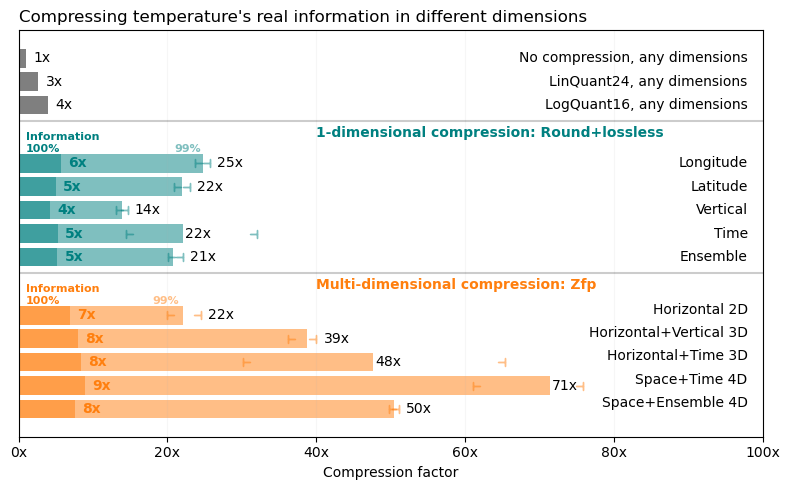

In [24]:
fig,ax1 = subplots(1,1,figsize=(8,5),sharex=true)

alfa = 0.5
alfa2 = 0.3
xmax = 100
color1 = "teal"
color2 = "C1"

i = 1.0
for (cf,label) in zip(cfs_basic,labels_basic)
    ax1.barh(i,cf,color="k",alpha=alfa)
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(cf+1,i,string(round(Int,cf))*"x",ha="left",va="center")
    i += 1
end

ax1.axhline(i-.3,color="k",alpha=.2)
ax1.text(40,i-.1,"1-dimensional compression: Round+lossless",va="top",color=color1,fontweight="bold")
i += 1.5

ax1.text(1,i-0.5,"Information\n100%",color=color1,fontweight="bold",fontsize=8)
ax1.text(21,i-0.5,"99%",color=color1,fontweight="bold",fontsize=8,alpha=alfa)

for (cf99,cf99min,cf99max,cf100,label) in zip(
        cfs_zstd99,cfs_zstd99min,cfs_zstd99max,cfs_zstd100,labels_zstd)
    ax1.barh(i,cf99,color=color1,alpha=alfa)
    ax1.barh(i,cf100,color=color1,alpha=alfa)
    ax1.plot(cf99min,i,color=color1,marker=L"$\vdash$",alpha=alfa)
    ax1.plot(cf99max,i,color=color1,marker=L"$\dashv$",alpha=alfa)
    offset = cf99max-cf99 > 3 ? .3 : cf99max-cf99+1.5
    ax1.text(xmax-2,i,label,ha="right",va="center")
    ax1.text(cf99+offset,i,string(round(Int,cf99))*"x",ha="left",va="center")
    ax1.text(cf100+1,i,string(round(Int,cf100))*"x",color=color1,ha="left",va="center",fontweight="bold")
    i += 1
end

ax1.axhline(i-.3,color="k",alpha=.2)
ax1.text(40,i-.1,"Multi-dimensional compression: Zfp",va="top",color=color2,fontweight="bold")
i += 1.5

ax1.text(1,i-0.5,"Information\n100%",color=color2,fontweight="bold",fontsize=8)
ax1.text(18,i-0.5,"99%",color=color2,fontweight="bold",fontsize=8,alpha=alfa)

for (cf99,cf99min,cf99max,cf100,label) in zip(
        cfs_zfp99,cfs_zfp99min,cfs_zfp99max,cfs_zfp100,labels_zfp)
    ax1.barh(i,cf99,color=color2,alpha=alfa)
    ax1.barh(i,cf100,color=color2,alpha=alfa)
    ax1.plot(cf99min,i,color=color2,marker=L"$\vdash$",alpha=alfa)
    ax1.plot(cf99max,i,color=color2,marker=L"$\dashv$",alpha=alfa)
    offset = cf99max-cf99 > 3 ? .3 : cf99max-cf99+1.5
    ax1.text(xmax-2,i-.25,label,ha="right",va="center")
    ax1.text(cf99+offset,i,string(round(Int,cf99))*"x",ha="left",va="center")
    ax1.text(cf100+1,i,string(round(Int,cf100))*"x",ha="left",va="center",color=color2,fontweight="bold")
    i += 1
end

ax1.xaxis.set_major_formatter(ticker.FormatStrFormatter("%dx"))
ax1.invert_yaxis()
ax1.set_yticks([])
ax1.set_xlim(0,xmax)
ax1.set_xlabel("Compression factor")
ax1.set_title("Compressing temperature's real information in different dimensions",loc="left")
ax1.grid(alpha=0.1)

tight_layout()
savefig("../plots/cfs_dimensions3.png",dpi=200)